## Introduction to Keras

In this example, we see how to build a neural network for binary classification using Keras.

We'll use scikit-learn to do the preprocessing (vectorizing and scaling of features), and Keras for the actual classification. It can also be useful to be aware that there are also wrapper classes that makes it easier to integrate Keras and scikit-learn, but we won't use it here. (You can read about the wrappers in [this document](https://keras.io/scikit-learn-api/).)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

%config InlineBackend.figure_format = 'svg' 
plt.style.use('bmh')

### Preprocessing

We first read the usual Adult dataset, and then apply standard scikit-learn functions to convert the data into a matrix.

In [2]:
import pandas as pd

train_data = pd.read_csv('data/adult_train.csv')

n_cols = len(train_data.columns)
Xtrain = train_data.iloc[:, :n_cols-1].to_dict('records')
Ytrain = train_data.iloc[:, n_cols-1]

test_data = pd.read_csv('data/adult_test.csv')
Xtest = test_data.iloc[:, :n_cols-1].to_dict('records')
Ytest = test_data.iloc[:, n_cols-1]

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Read the Adult dataset. (See lecture9.py for the code.)

# A Pipeline combining the vectorizer and scaler.
pipeline = make_pipeline(
    DictVectorizer(sparse=False),
    StandardScaler(with_mean=False),
)

# Convert the Adult dataset into a matrix.
Xv = pipeline.fit_transform(Xtrain)

# Apply the same transformation to the test set.
Xtest_v = pipeline.transform(Xtest)

When training a binary classifier in Keras, the class labels need to be coded as 0/1 or `False`/`True`. The code below will convert `Ytrain` and `Ytest` into Boolean values.

In [4]:
Yv = np.array(Ytrain) == '>50K'
Ytest_v = np.array(Ytest) == '>50K'

### Training a neural network using Keras

We make a `Sequential` model and add two layers. We then `compile` the model (which means that Keras will generate a computation graph in TensorFlow). Finally, we `fit` the model.

A few comments:
* `binary_crossentropy` is the same as the log loss. This is typically what we use when using a `sigmoid` in the output layer. See [this document](https://keras.io/losses) for a list of the loss functions available in Keras.
* The `optimizer` is set to `sgd`, for stochastic gradient descent. If you want to modify the learning rate, you need to create an `Optimizer` object, see [here](https://keras.io/optimizers/).
* `metrics=['accuracy']` means that we print the accuracy during training.
* `epochs=20` means that the training process iterates 20 times through the training set.
* `verbose=2` means that we print some information after each epoch. (Set `verbose=0` to disable these messages.)
* `batch_size=400` is the minibatch size.

In [5]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def make_model():
    model = Sequential()
    model.add(Dense(units=16, activation='relu', input_dim=Xv.shape[1]))
    model.add(Dense(units=1, activation='sigmoid'))
    return model

model = make_model()
model.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

history = model.fit(Xv, Yv, epochs=20, verbose=2, batch_size=400)

Epoch 1/20
82/82 - 0s - loss: 0.5807 - accuracy: 0.7191 - 402ms/epoch - 5ms/step
Epoch 2/20
82/82 - 0s - loss: 0.4729 - accuracy: 0.7844 - 88ms/epoch - 1ms/step
Epoch 3/20
82/82 - 0s - loss: 0.4316 - accuracy: 0.8030 - 83ms/epoch - 1ms/step
Epoch 4/20
82/82 - 0s - loss: 0.4060 - accuracy: 0.8146 - 88ms/epoch - 1ms/step
Epoch 5/20
82/82 - 0s - loss: 0.3893 - accuracy: 0.8210 - 82ms/epoch - 1ms/step
Epoch 6/20
82/82 - 0s - loss: 0.3777 - accuracy: 0.8255 - 84ms/epoch - 1ms/step
Epoch 7/20
82/82 - 0s - loss: 0.3694 - accuracy: 0.8288 - 83ms/epoch - 1ms/step
Epoch 8/20
82/82 - 0s - loss: 0.3631 - accuracy: 0.8308 - 85ms/epoch - 1ms/step
Epoch 9/20
82/82 - 0s - loss: 0.3583 - accuracy: 0.8346 - 88ms/epoch - 1ms/step
Epoch 10/20
82/82 - 0s - loss: 0.3543 - accuracy: 0.8360 - 82ms/epoch - 1ms/step
Epoch 11/20
82/82 - 0s - loss: 0.3510 - accuracy: 0.8379 - 80ms/epoch - 973us/step
Epoch 12/20
82/82 - 0s - loss: 0.3482 - accuracy: 0.8385 - 94ms/epoch - 1ms/step
Epoch 13/20
82/82 - 0s - loss: 0.3

We predict the outputs. (Note that in Keras, we need to call `predict_classes`. The method `predict` gives probability outputs.)

The accuracy is around 0.85, like we typically see for this dataset.

In [6]:
Yguess_v = (model.predict(Xtest_v)> 0.5).astype("int32")
accuracy_score(Ytest_v, Yguess_v)

0.8466924636078865

The method `fit` returns a `History` object, which contains logs of all the metrics computed during training. We plot the loss over the 20 epochs.

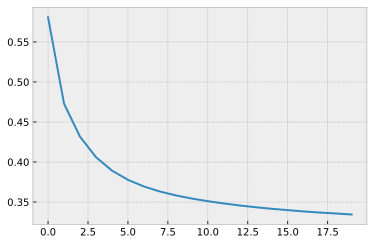

In [7]:
plt.plot(history.history['loss']);

And the accuracy (evaluated on the training set) over the 20 epochs.

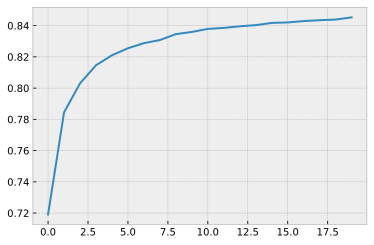

In [8]:
plt.plot(history.history['accuracy']);

### Example of overfitting

Above, we trained the model for just 20 epochs. How many epochs do we need? It can be harmful to let the training process go on for too long, because we may suffer from *overfitting*.

In the following example, we let the model train for 2000 epochs. (NB: this takes some minutes!)

For each epoch, we plot the loss on the *training set* as well as on a held-out *validation set*. In the beginning, the training and validation loss both decrease, but after a while the validation loss starts to increase again. This is when we have started to see some overfitting.

In [9]:
model = make_model()
model.compile(loss='binary_crossentropy',
              optimizer='adam')
history = model.fit(Xv, Yv, epochs=2000, verbose=0, batch_size=400, validation_split=0.1)

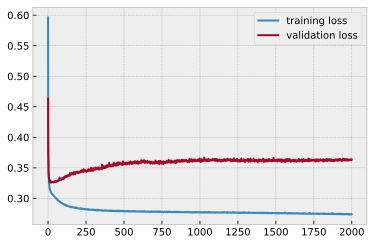

In [10]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.legend(['training loss', 'validation loss']);

### Early stopping

We use *early stopping*, using a held-out validation set, to determine when to terminate the training process. The purpose is to avoid the overfitting we saw above.

To do this, we need to create a *callback* that is called after each epoch. Note that we provide this callback when calling `fit`.

In [11]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(monitor='val_loss', 
                                         min_delta=0, patience=10, verbose=0, mode='auto')

model = make_model()
model.compile(loss='binary_crossentropy',
              optimizer='sgd')

history = model.fit(Xv, Yv, epochs=2000, verbose=0, batch_size=400,
                    validation_split=0.1, callbacks=[early_stopping])

The early stopping criterion will terminate the SGD training process after a few hundred epochs.

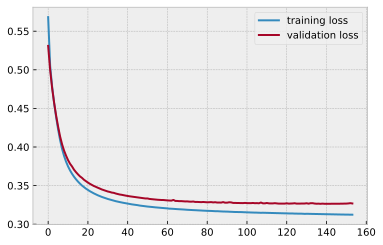

In [12]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.legend(['training loss', 'validation loss']);

### Using an adaptive optimizer

Stochastic gradient descent is a bit inflexible; instead it's better to use an optimization method that adapts the learning rate during training, to accellerate and slow down when necessary.

Keras includes several optimizers. We use [Adam](https://arxiv.org/pdf/1412.6980.pdf), one of the most popular optimization methods for neural networks.

In [13]:
model = make_model()
model.compile(loss='binary_crossentropy',
              optimizer='adam')
adam_history = model.fit(Xv, Yv, epochs=2000, verbose=0, batch_size=400,
                         validation_split=0.1, callbacks=[early_stopping])

As you can see, using Adam makes the model learn much faster than when we used SGD.

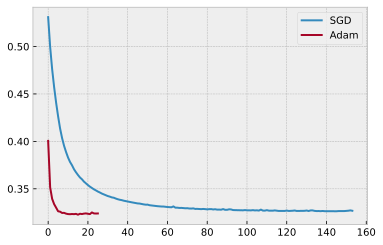

In [14]:
plt.plot(history.history['val_loss']);
plt.plot(adam_history.history['val_loss']);
plt.legend(['SGD', 'Adam']);

### Using dropout




*Dropout* is a method to train neural networks to make them more robust. (See for instance [this explanation](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/).)

In Keras, we just add a `Dropout` after each layer. The probability of dropping a unit needs to be specified.

In [15]:
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=Xv.shape[1]))
model.add(Dropout(0.1))
model.add(Dense(units=1, activation='sigmoid'))
model.add(Dropout(0.1))
model.compile(loss='binary_crossentropy',
              optimizer='adam')
model.fit(Xv, Yv, epochs=2000, verbose=0, batch_size=400, 
          validation_split=0.1, callbacks=[early_stopping]);

In this particular case, dropout does not seem to have an effect on the quality of the classifier.

In [16]:
Yguess_v = (model.predict(Xtest_v)> 0.5).astype("int32")
accuracy_score(Ytest_v, Yguess_v)

0.8506234260794792